# Compare likelihoods using different theory objects

In this notebook we compare the old theory (lya_theory) that uses compressed likelihood parameters ($\Delta_p^2$, $n_p$), with the new theory (full_theory) that uses CMB parameters ($A_s$, $n_s$).

We start by comparing emulator calls, P1D predictions and likelihood evaluations for the fiducial model.

We then redo the exercise for a test cosmology, where we only change primordial power spectrum parameters.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
# our modules
import data_MPGADGET
import p1d_arxiv
import gp_emulator
import likelihood
import likelihood_parameter
import lya_theory
import full_theory
import camb_cosmo
import CAMB_model
import linear_power_model

In [2]:
# specify verbosity for all objects (except emulator)
verbose=False

### Setup mock data, from one of simulations in the suite

In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data
test_sim_num=15
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,basedir=basedir,skewers_label=skewers_label,data_cov_factor=1)

### Setup archive of P1D measurements from simulations and train the emulator

In [4]:
# specify redshift range
z_max=4
# specify pivot point to be used in emulator (slow)
emu_kp_Mpc=None
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label,
                            kp_Mpc=emu_kp_Mpc)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


### Setup fiducial cosmology

In [6]:
# Fiducial cosmology 
cosmo_fid=camb_cosmo.get_cosmology()
camb_cosmo.print_info(cosmo_fid)
# compute linP parameters
linP_fid=linear_power_model.LinearPowerModel(cosmo=cosmo_fid)
old_like_params_fid=linP_fid.get_likelihood_parameters()
print('old likelihood parameters for fiducial cosmology')
for par in old_like_params_fid:
    print(par.info_str())

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00
old likelihood parameters for fiducial cosmology
g_star = 0.9677508579459803
f_star = 0.981369557840318
Delta2_star = 0.36017590528641974
n_star = -2.299335667257498
alpha_star = -0.2165270371206895


In [7]:
# setup camb model (needed in full_theory)
camb_model_fid=CAMB_model.CAMBModel(zs=data.z,cosmo=cosmo_fid)
new_like_params_fid=camb_model_fid.get_likelihood_parameters()
print('new likelihood parameters for fiducial cosmology')
for par in new_like_params_fid:
    print(par.info_str())

new likelihood parameters for fiducial cosmology
ombh2 = 0.022
omch2 = 0.12
As = 2.1e-09
ns = 0.965
H0 = 67.0
mnu = 0.0


### Setup and compare theory objects for fiducial cosmology

Start by setting up an old theory object, that uses only compressed linP parameters

In [8]:
old_theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,cosmo_fid=cosmo_fid,verbose=verbose)
old_emu_calls_fid=old_theory.get_emulator_calls()

In [9]:
# we want to study also cases where we ignore some of the parameters (although here we expect equal results)
cull_params=['f_star','g_star','alpha_star']
culled_like_params_fid = [par for par in old_like_params_fid if par.name not in cull_params]
for par in culled_like_params_fid:
    print(par.info_str())
culled_emu_calls_fid=old_theory.get_emulator_calls(like_params=culled_like_params_fid)

Delta2_star = 0.36017590528641974
n_star = -2.299335667257498


Setup now a new theory object, that holds a CAMB object

In [10]:
new_theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_fid,verbose=verbose)
new_emu_calls_fid=new_theory.get_emulator_calls(return_M_of_z=False)

In [11]:
print("z=2 emulator calls for old theory = ", old_emu_calls_fid[0])
print("z=2 emulator calls for new theory = ", new_emu_calls_fid[0])

z=2 emulator calls for old theory =  {'Delta2_p': 0.6362068065698854, 'n_p': -2.302948958159187, 'alpha_p': -0.21533440645116048, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z=2 emulator calls for new theory =  {'Delta2_p': 0.6363721329208487, 'n_p': -2.3025650376301496, 'alpha_p': -0.2149705876861655, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}


Both new and old theories make the same emulator call for a theory that is not the fiducial!

## Compare likelihood evaluations for the fiducial cosmology

### Old likelihood using all five parameters

In [12]:
## Set up a likelihood object with the old theory object
#old_free_params=['Delta2_star','n_star']
old_free_params=['Delta2_star','n_star','alpha_star','f_star','g_star']
old_like=likelihood.Likelihood(data=data,theory=old_theory,
                            free_parameters=old_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [13]:
# get parameter values in cube for fiducial cosmology
old_values_fid=old_like.sampling_point_from_parameters(old_like_params_fid)
# check that parameters inferred from these are same than computed before
for par in old_like.parameters_from_sampling_point(values=old_values_fid):
    print(par.info_str(),',',par.value_in_cube())

g_star = 0.9677508579459803 , 0.4437714486495072
f_star = 0.981369557840318 , 0.7842389460079501
Delta2_star = 0.36017590528641974 , 0.7345060352427981
n_star = -2.299335667257498 , 0.5066433274250222
alpha_star = -0.2165270371206895 , 0.4861178443573684


### Old likelihood using only two parameters (should not make a different, no change in growth / expansion)

In [14]:
## Set up a likelihood object with the old theory object, but now with only 2 key parameters
culled_free_params=['Delta2_star','n_star']
culled_like=likelihood.Likelihood(data=data,theory=old_theory,
                            free_parameters=culled_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [15]:
# get parameter values in cube for fiducial cosmology
culled_values_fid=culled_like.sampling_point_from_parameters(culled_like_params_fid)
# check that parameters inferred from these are same than computed before
for par in culled_like.parameters_from_sampling_point(values=culled_values_fid):
    print(par.info_str(),',',par.value_in_cube())

Delta2_star = 0.36017590528641974 , 0.7345060352427981
n_star = -2.299335667257498 , 0.5066433274250222


### New likelihood

In [16]:
## Set up a likelihood object with the new theory object
new_free_params=["As","ns"]
new_like=likelihood.Likelihood(data=data,theory=new_theory,
                            free_parameters=new_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [17]:
# get parameter values in cube for fiducial cosmology in new theory
new_values_fid=new_like.sampling_point_from_parameters(new_like_params_fid)
# check that parameters inferred from these are same than computed before
for par in new_like.parameters_from_sampling_point(values=new_values_fid):
    print(par.info_str(),',',par.value_in_cube())

As = 2.1e-09 , 0.500000000000001
ns = 0.965 , 0.5


### Compare chi2 for fiducial model

In [18]:
old_chi2_fid=old_like.get_chi2(values=old_values_fid)
culled_chi2_fid=culled_like.get_chi2(values=culled_values_fid)
new_chi2_fid=new_like.get_chi2(values=new_values_fid)
print('old chi2 for fiducial theory =',old_chi2_fid)
print('culled chi2 for fiducial theory =',culled_chi2_fid)
print('new chi2 for fiducial theory =',new_chi2_fid)

old chi2 for fiducial theory = 837.9137815860871
culled chi2 for fiducial theory = 837.9137815860871
new chi2 for fiducial theory = 839.8565304963794


### P1D predictions from the different theories (fiducial cosmology)

In [19]:
zs=data.z
k_kms=np.logspace(np.log10(min(data.k)),np.log10(max(data.k)),500)
old_p1d_fid=old_like.get_p1d_kms(k_kms=k_kms,values=old_values_fid,return_covar=False)
culled_p1d_fid=culled_like.get_p1d_kms(k_kms=k_kms,values=culled_values_fid,return_covar=False)
new_p1d_fid=new_like.get_p1d_kms(k_kms=k_kms,values=new_values_fid,return_covar=False)

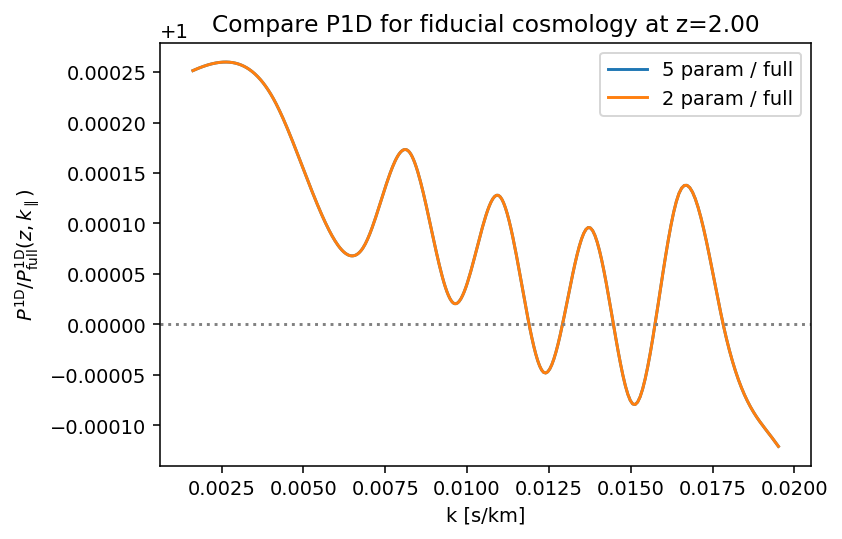

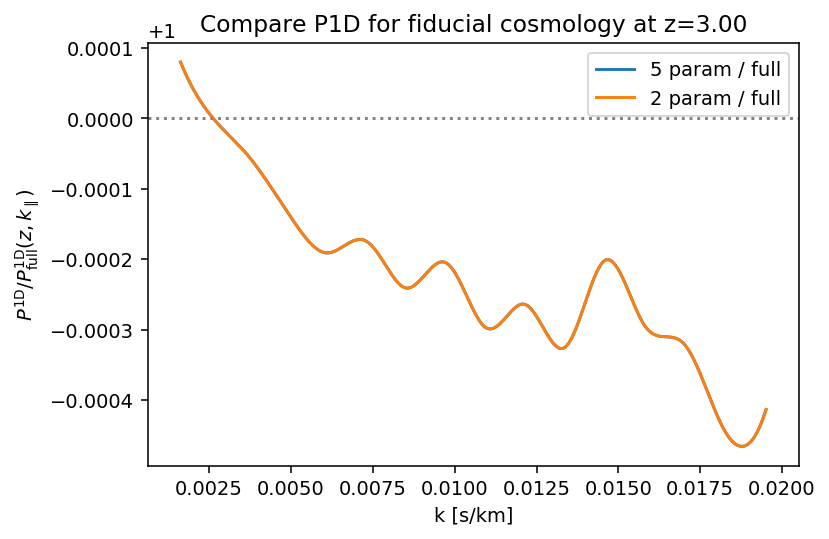

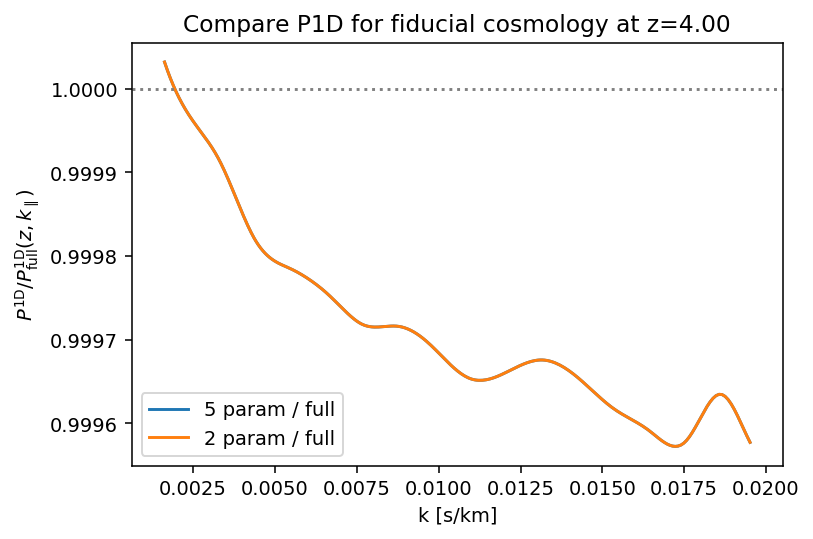

In [20]:
for iz in range(0,len(zs),4):
    z=zs[iz]
    plt.figure()
    plt.plot(k_kms,old_p1d_fid[iz]/new_p1d_fid[iz],label='5 param / full')
    plt.plot(k_kms,culled_p1d_fid[iz]/new_p1d_fid[iz],label='2 param / full')
    plt.legend()
    plt.xlabel('k [s/km]')
    plt.ylabel(r'$P^{\rm 1D} / P^{\rm 1D}_{\rm full} (z,k_\parallel)$')
    plt.xlim(min(k_kms)-0.001,max(k_kms)+0.001)
    plt.axhline(y=1,ls=':',color='gray')
    plt.title('Compare P1D for fiducial cosmology at z={:.2f}'.format(z))

I think these plots look pretty good!

# Compare now theory objects when using a test cosmology

In [21]:
# Setup test cosmology (varying only primordial power parameters)
cosmo_test=camb_cosmo.get_cosmology(As=1.9e-9,ns=0.92)
camb_cosmo.print_info(cosmo_test)
# compute linP parameters for test cosmology
linP_test=linear_power_model.LinearPowerModel(cosmo=cosmo_test)
old_like_params_test=linP_test.get_likelihood_parameters()
print('old likelihood parameters for test cosmology')
for par in old_like_params_test:
    print(par.info_str())

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 1.9000E-09, n_s = 9.2000E-01, alpha_s = 0.0000E+00
old likelihood parameters for test cosmology
g_star = 0.9677508579459803
f_star = 0.9813695578403181
Delta2_star = 0.28957717426109336
n_star = -2.344335667257508
alpha_star = -0.21652703712062632


In [22]:
# setup camb model (needed in full_theory) for test cosmology
camb_model_test=CAMB_model.CAMBModel(zs=data.z,cosmo=cosmo_test)
new_like_params_test=camb_model_test.get_likelihood_parameters()
print('new likelihood parameters for test cosmology')
for par in new_like_params_test:
    print(par.info_str())

new likelihood parameters for test cosmology
ombh2 = 0.022
omch2 = 0.12
As = 1.9e-09
ns = 0.92
H0 = 67.0
mnu = 0.0


### Start by comparing emulator calls for the test cosmology

In [23]:
# call the old theory, but using the freshly computed likelihood parameters from the test cosmology
old_emu_calls_test=old_theory.get_emulator_calls(like_params=old_like_params_test)

In [24]:
# we want to study also cases where we ignore some of the parameters (although here we expect equal results)
culled_like_params_test = [par for par in old_like_params_test if par.name not in cull_params]
for par in culled_like_params_test:
    print(par.info_str())
culled_emu_calls_test=old_theory.get_emulator_calls(like_params=culled_like_params_test)

Delta2_star = 0.28957717426109336
n_star = -2.344335667257508


In [25]:
# call the new theory, but using the freshly computed likelihood parameters for the test cosmology
new_emu_calls_test=new_theory.get_emulator_calls(like_params=new_like_params_test,return_M_of_z=False)

In [26]:
print("z = {} emulator calls from old theory = {}".format(data.z[0],old_emu_calls_test[0]))
print("z = {} emulator calls from culled theory = {}".format(data.z[0],culled_emu_calls_test[0]))
print("z = {} emulator calls from new theory = {}".format(data.z[0],new_emu_calls_test[0]))

z = 2.0 emulator calls from old theory = {'Delta2_p': 0.5111730453060189, 'n_p': -2.3479489581591944, 'alpha_p': -0.21533440645109772, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z = 2.0 emulator calls from culled theory = {'Delta2_p': 0.5111730453060183, 'n_p': -2.3479489581591966, 'alpha_p': -0.21533440645114824, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z = 2.0 emulator calls from new theory = {'Delta2_p': 0.5112928246742909, 'n_p': -2.3475650376301496, 'alpha_p': -0.2149705876861655, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}


In [27]:
print("z = {} emulator calls from old theory = {}".format(data.z[-1],old_emu_calls_test[-1]))
print("z = {} emulator calls from culled theory = {}".format(data.z[-1],culled_emu_calls_test[-1]))
print("z = {} emulator calls from new theory = {}".format(data.z[-1],new_emu_calls_test[-1]))

z = 4.0 emulator calls from old theory = {'Delta2_p': 0.1882215338666894, 'n_p': -2.3478820884420286, 'alpha_p': -0.21537954499411333, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.1124868806234996, 'kF_Mpc': 12.841201989686333}
z = 4.0 emulator calls from culled theory = {'Delta2_p': 0.1882215338666894, 'n_p': -2.3478820884420304, 'alpha_p': -0.2153795449941673, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.1124868806234996, 'kF_Mpc': 12.841201989686333}
z = 4.0 emulator calls from new theory = {'Delta2_p': 0.188307062961472, 'n_p': -2.3475655917505174, 'alpha_p': -0.21497095777387204, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.1124868806234996, 'kF_Mpc': 12.841201989686333}


### Compare now likelihood parameters for the test cosmology

In [28]:
# get parameter values in cube for test cosmology
old_values_test=old_like.sampling_point_from_parameters(old_like_params_test)
# check that parameters inferred from these are same than computed before
for par in old_like.parameters_from_sampling_point(values=old_values_test):
    print(par.info_str(),',',par.value_in_cube())

g_star = 0.9677508579459803 , 0.4437714486495072
f_star = 0.9813695578403181 , 0.7842389460079529
Delta2_star = 0.28957717426109336 , 0.26384782840728904
n_star = -2.344335667257508 , 0.056643327424921126
alpha_star = -0.21652703712062632 , 0.48611784435794264


In [29]:
# get parameter values in cube for test cosmology
culled_values_test=culled_like.sampling_point_from_parameters(culled_like_params_test)
# check that parameters inferred from these are same than computed before
for par in culled_like.parameters_from_sampling_point(values=culled_values_test):
    print(par.info_str(),',',par.value_in_cube())

Delta2_star = 0.28957717426109336 , 0.26384782840728904
n_star = -2.344335667257508 , 0.056643327424921126


In [30]:
# get parameter values in cube for test cosmology
new_values_test=new_like.sampling_point_from_parameters(new_like_params_test)
# check that parameters inferred from these are same than computed before
for par in new_like.parameters_from_sampling_point(values=new_values_test):
    print(par.info_str(),',',par.value_in_cube())

As = 1.9e-09 , -0.500000000000001
ns = 0.92 , -0.9999999999999963


### Compare chi2 for test cosmology

In [31]:
old_chi2_test=old_like.get_chi2(values=old_values_test)
culled_chi2_test=culled_like.get_chi2(values=culled_values_test)
new_chi2_test=new_like.get_chi2(values=new_values_test)
print('old chi2 for test theory =',old_chi2_test)
print('culled chi2 for test theory =',culled_chi2_test)
print('new chi2 for test theory =',new_chi2_test)

old chi2 for test theory = 154.44061400566412
culled chi2 for test theory = 154.44061401495873
new chi2 for test theory = 159.0951528820708


### P1D predictions from the different theories (test cosmology)

In [32]:
old_p1d_test=old_like.get_p1d_kms(k_kms=k_kms,values=old_values_test,return_covar=False)
culled_p1d_test=culled_like.get_p1d_kms(k_kms=k_kms,values=culled_values_test,return_covar=False)
new_p1d_test=new_like.get_p1d_kms(k_kms=k_kms,values=new_values_test,return_covar=False)

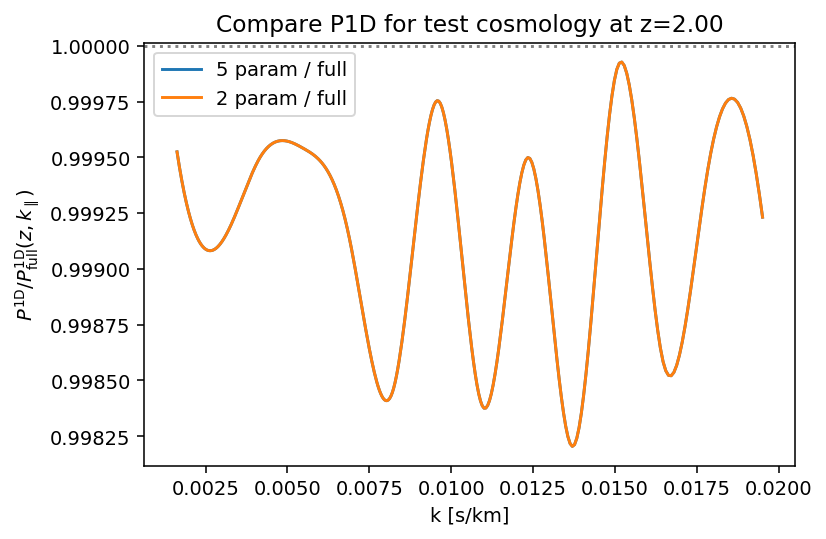

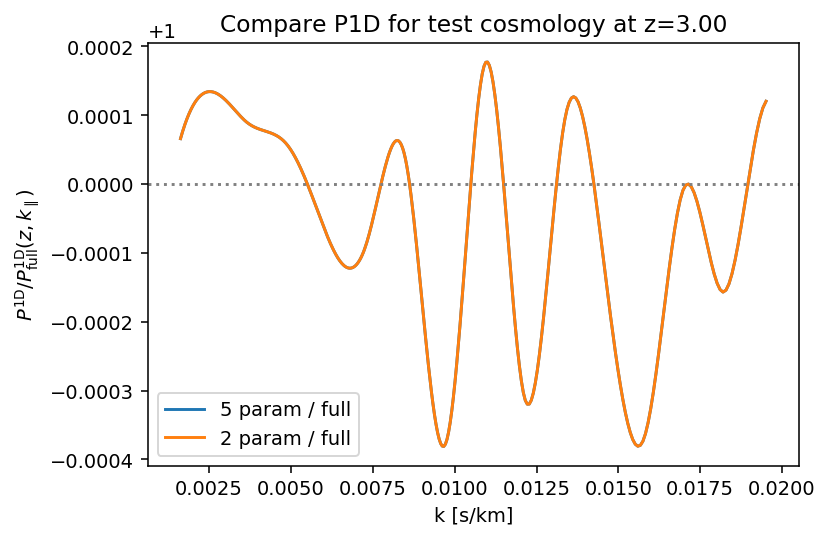

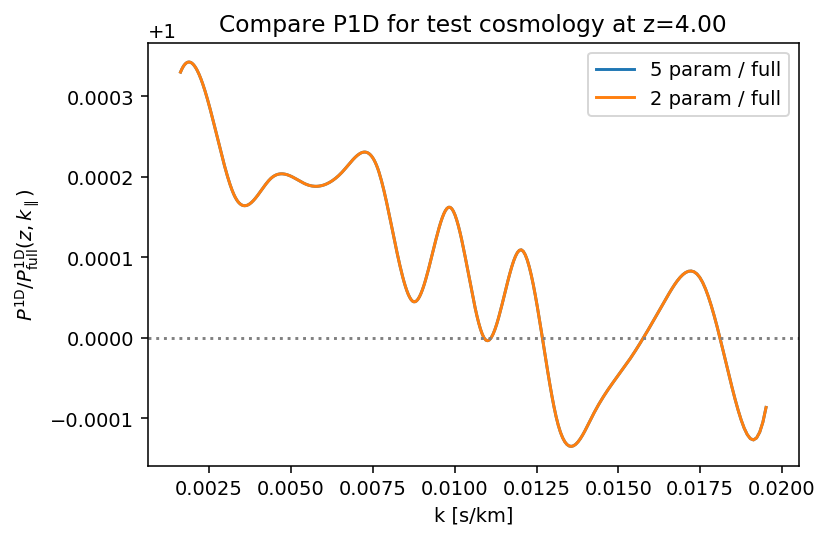

In [33]:
for iz in range(0,len(zs),4):
    z=zs[iz]
    plt.figure()
    plt.plot(k_kms,old_p1d_test[iz]/new_p1d_test[iz],label='5 param / full')
    plt.plot(k_kms,culled_p1d_test[iz]/new_p1d_test[iz],label='2 param / full')
    plt.legend()
    plt.xlabel('k [s/km]')
    plt.ylabel(r'$P^{\rm 1D} / P^{\rm 1D}_{\rm full} (z,k_\parallel)$')
    plt.xlim(min(k_kms)-0.001,max(k_kms)+0.001)
    plt.axhline(y=1,ls=':',color='gray')
    plt.title('Compare P1D for test cosmology at z={:.2f}'.format(z))